In [1]:
# 
# Optimizing with TensorBoard - Deep Learning with Python, TensorFlow & Keras
# Steg 4 - analys av hur CNN-geometrin påverkar resultat från körning
#        - samt val optimalt kombinerade parametrar

In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
# more info on callbakcs: https://keras.io/callbacks/ model saver is cool too.
from tensorflow.keras.callbacks import TensorBoard
import pickle
import time


In [3]:
#
# Läser in tidigare sparat data från disk 

DATADIR = "C:\\LTH_data\\photo\\PythUtbPic\\SKARP\\"     # path till katalog med djurbilder
DATADIR_MOD = DATADIR                                    # path till sparad modell

TxT_INPmod_fileN = DATADIR_MOD + "X_train.pickle"        # Filnamn indata
TxT_OUTmod_fileN = DATADIR_MOD + "y_train.pickle"        # Filnamn utdata

print(f"  {TxT_INPmod_fileN  =  }")
print(f"  {TxT_OUTmod_fileN  =  }")

pickle_in = open(TxT_INPmod_fileN,"rb")         # Läs Indata - bildmatrl
X_train = pickle.load(pickle_in)

pickle_in = open(TxT_OUTmod_fileN,"rb")         # Läs Utdata - (0/1) (katt/hund)
y_train = pickle.load(pickle_in)

X_train = X_train/255.0                         # Normera gråskallenivå, (0,255) transformeras till (0,1), utan medlevärdesförskjutning


  TxT_INPmod_fileN  =  'C:\\LTH_data\\photo\\PythUtbPic\\SKARP\\X_train.pickle'
  TxT_OUTmod_fileN  =  'C:\\LTH_data\\photo\\PythUtbPic\\SKARP\\y_train.pickle'


In [4]:
#
# Optimering map densitet, storlek och conv
#

if False:
    # Ungefär samma värden som i steg3 - 1st try
    dense_layers = [0, 1]
    layer_sizes = [64]
    conv_layers = [1, 2]
    epochs_numb = 20
    TxT_NAME = "OPT_1st_"             # Början på loggfilen
    TxT_LOG_DIR = "log_steg4_Opt1"    # Pathen att spara under
    
elif False:
    # Ny Snurra  -  2nd try
    dense_layers = [1, 2]
    layer_sizes = [64]
    conv_layers = [2, 3]
    epochs_numb = 15
    TxT_NAME = "OPT_2nd_"
    TxT_LOG_DIR = "log_steg4_Opt2"
    
elif False:
    # Ny Snurra  -  3rd try
    dense_layers = [1, 2]
    layer_sizes = [16, 32, 64]
    conv_layers = [3]
    epochs_numb = 15
    TxT_NAME = "OPT_3rd_"
    TxT_LOG_DIR = "log_steg4_eOpt3"
    
elif False:
    # Ny Snurra  -  4th try
    dense_layers = [2]
    layer_sizes = [32, 128, 256, 512]
    conv_layers = [3]
    epochs_numb = 17
    TxT_NAME = "OPT_4th_"
    TxT_LOG_DIR = "log_steg4_Opt4"
    
elif True:
    # Ny Snurra  -  5th try            Bästa alternativet av alla testade kombinationer
    dense_layers = [2]
    layer_sizes = [256]
    conv_layers = [3]
    epochs_numb = 5
    TxT_NAME = "OPT_5th_"
    TxT_LOG_DIR = "log_steg4_Opt5"




In [5]:
#
# Snurran för optimeringsanalys

snurra_number = 0

for dense_layer in dense_layers:
    for layer_size in layer_sizes:
        for conv_layer in conv_layers:
            print("="*40)
            snurra_number += 1
            print(f"   {snurra_number  =  }")
            named_tuple = time.localtime()                                # get struct_time
            time_string = time.strftime("%Y%m%d-%H%M", named_tuple)       # läsbart format
            TxT_LOGG_fNAME = "CNN-{}".format(time_string)
            TxT_LOGG_fNAME = "{}-conv-{}-nodes-{}-dense-{}".format(conv_layer, layer_size, dense_layer, TxT_LOGG_fNAME)
            TxT_LOGG_fNAME = "{}model-{}".format(TxT_NAME, TxT_LOGG_fNAME)
            print(f"  {TxT_LOGG_fNAME  =  }")

            model = Sequential()

            model.add(Conv2D(layer_size, (3, 3), input_shape=X_train.shape[1:]))
            model.add(Activation('relu'))
            model.add(MaxPooling2D(pool_size=(2, 2)))

            for l in range(conv_layer-1):
                model.add(Conv2D(layer_size, (3, 3)))
                model.add(Activation('relu'))
                model.add(MaxPooling2D(pool_size=(2, 2)))

            model.add(Flatten())

            for _ in range(dense_layer):
                model.add(Dense(layer_size))         # Lägg till ett Dense lager med "layer_size" antal neuroner, fullt kopplade Upp/Ned 
                model.add(Activation('relu'))        # Rectified Linear Unit
                model.add(Dropout(0.2))              # droppa 20% av neuronerna för att förhindra överträning (overfitting) 

            model.add(Dense(1))
            model.add(Activation('sigmoid'))

            #tensorboard = TensorBoard(log_dir="logs/{}".format(TxT_LOGG_fNAME))
            TxT_LOG_DIR_and_fNAME = "{}/{}".format(TxT_LOG_DIR, TxT_LOGG_fNAME)
            print(f"  {TxT_LOG_DIR_and_fNAME  =  }")
            tensorboard = TensorBoard(log_dir=TxT_LOG_DIR_and_fNAME)
            
            model.compile(loss='binary_crossentropy',
                          optimizer='adam',
                          metrics=['accuracy'],
                          )

            model.fit(X_train, y_train,
                      batch_size=32,
                      epochs=epochs_numb,
                      validation_split=0.3,
                      callbacks=[tensorboard])


# Samtidigt som modellen tränas
# Starta en CMD från samma path som detta -->  C:\Users\larth\PythUtb\InlUppg_2\SKARP\Cats_and_Dogs>
# Kör från CMD  -->  kör kommandot:   tensorboard --logdir='log_steg4_Opt1'
# Kör från web browser    -->  http://localhost:6006/ 
#
# Enstaka logg-filer
# Kör från CMD  -->  kör kommandot:   tensorboard --logdir='log_steg4_Opt1\OPT_1st_model-1-conv-64-nodes-0-dense-CNN-20250522-1952'
# Kör från CMD  -->  kör kommandot:   tensorboard --logdir=log_steg4_Opt1\OPT_1st_model-1-conv-64-nodes-1-dense-CNN-20250522-2002'
#
# Analysera samtliga loggfiler från samma katalog
# Kör från CMD  -->     tensorboard --logdir='log_steg4_Opt1'
# Kör från CMD  -->     tensorboard --logdir='log_steg4_Opt2'
# Kör från CMD  -->     tensorboard --logdir='log_steg4_Opt3'
# Kör från CMD  -->     tensorboard --logdir='log_steg4_Opt4'
# Kör från CMD  -->     tensorboard --logdir=log_steg4_Opt5\
#



   snurra_number  =  1
  TxT_LOGG_fNAME  =  'OPT_5th_model-3-conv-256-nodes-2-dense-CNN-20250523-0646'


C:\Users\larth\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


  TxT_LOG_DIR_and_fNAME  =  'log_steg4_Opt5/OPT_5th_model-3-conv-256-nodes-2-dense-CNN-20250523-0646'
Epoch 1/5
169/169 ━━━━━━━━━━━━━━━━━━━━ 276s 2s/step - accuracy: 0.5578 - loss: 0.6720 - val_accuracy: 0.8312 - val_loss: 0.3839
Epoch 2/5
169/169 ━━━━━━━━━━━━━━━━━━━━ 270s 2s/step - accuracy: 0.8258 - loss: 0.3957 - val_accuracy: 0.8610 - val_loss: 0.3169
Epoch 3/5
169/169 ━━━━━━━━━━━━━━━━━━━━ 270s 2s/step - accuracy: 0.8580 - loss: 0.3241 - val_accuracy: 0.8680 - val_loss: 0.2934
Epoch 4/5
169/169 ━━━━━━━━━━━━━━━━━━━━ 269s 2s/step - accuracy: 0.8837 - loss: 0.2667 - val_accuracy: 0.8775 - val_loss: 0.2643
Epoch 5/5
169/169 ━━━━━━━━━━━━━━━━━━━━ 265s 2s/step - accuracy: 0.9021 - loss: 0.2261 - val_accuracy: 0.8835 - val_loss: 0.2584


In [44]:
#
# Spara modellen som en '.keras'-fil för framtida behov

TxT_MODEL_fName = DATADIR_MOD + 'steg4_256x3x5-CNN.keras'    # Anpassad modell (256 noder/lager, 3-convlager & 5 epochs)
print(f"  {TxT_MODEL_fName  =  }")

model.save(TxT_MODEL_fName)     # Sparar Modellen som ska användas för framtida TEST-prediktion


  TxT_MODEL_fName  =  'C:\\LTH_data\\photo\\PythUtbPic\\SKARP\\steg4_256x3x5-CNN.keras'


In [6]:
#
# SLUTSATS :: Utifrån använt underlag av bilder på katter och hundar, visar utvärdering på träning och validering att
#    i. 5 stegs epochs ger god respons - varken under- eller överanpassat
#    ii. Optimum vid: 256 noder per lager       layer_sizes = [256]
#                      2 density               dense_layers = [2]
#                      3 extra convolution      conv_layers = [3]
#
#   iii.  5 steg iteration 'epochs' --> accuracy: (train, val) ~ (0.90, 0.88)  [1 är optimalt, 0 påvisar fullständigt oberoende]
#                                   -->     loss: (train, val) ~ (0.23, 0.26) 
#

In [34]:


#####################################################################
# Visualisera med feature maps
# Inför funktionen "visualisera_feature_maps()"


import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt


def visualize_feature_maps(model, image, layer_limit=None):
    """
    Visualiserar feature maps från alla Conv2D-lager i modellen för en given bild.

    Parametrar:
    - model: Tränad Keras Sequential-modell med Conv2D-lager.
    - image: En bild med shape (28,28,1) eller (1,28,28,1).
    - layer_limit: (valfritt) Begränsar hur många Conv2D-lager som visualiseras.
    """
    # Se till att bilden har rätt batch-dimension
    if image.ndim == 3:
        img_input = np.expand_dims(image, axis=0)
    else:
        img_input = image

    # Hämta utgångar från alla Conv2D-lager
    conv_layers = [layer for layer in model.layers if isinstance(layer, tf.keras.layers.Conv2D)]
    if layer_limit:
        conv_layers = conv_layers[:layer_limit]

    layer_outputs = [layer.output for layer in conv_layers]
    layer_names = [layer.name for layer in conv_layers]

    # Skapa modell som ger tillgång till mellanliggande aktiveringar
    activation_model = tf.keras.models.Model(inputs=model.layers[0].input, outputs=layer_outputs)

    # Få aktiveringar från bilden
    activations = activation_model.predict(img_input)

    # Visualisera varje lager
    for layer_name, layer_activation in zip(layer_names, activations):
        n_features = layer_activation.shape[-1]  # antal feature maps
        size = layer_activation.shape[1]         # höjd/bredd på varje map

        n_cols = min(n_features, 20)  # visa max 20 kolumner eller minsta antalet filter per lager
        display_grid = np.zeros((size, n_cols * size))

        for col in range(n_cols):
            channel_image = layer_activation[0, :, :, col]
            channel_image -= channel_image.mean()
            channel_image /= (channel_image.std() + 1e-5)
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[:, col * size : (col + 1) * size] = channel_image

        scale = 1. / size
        plt.figure(figsize=(scale * display_grid.shape[1], scale * display_grid.shape[0]))
        plt.title(f"Feature maps from layer: {layer_name}")
        plt.grid(False)
        plt.imshow(display_grid, aspect='auto', cmap='viridis')
        plt.axis('off')
        plt.show()



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


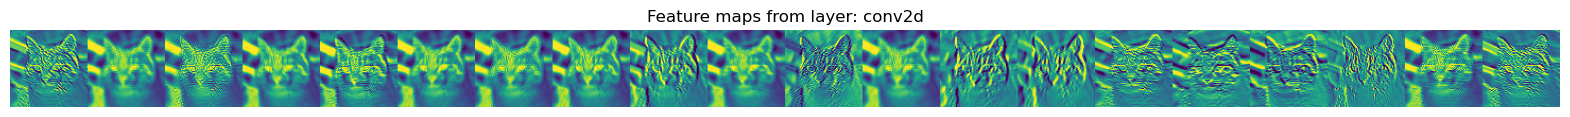

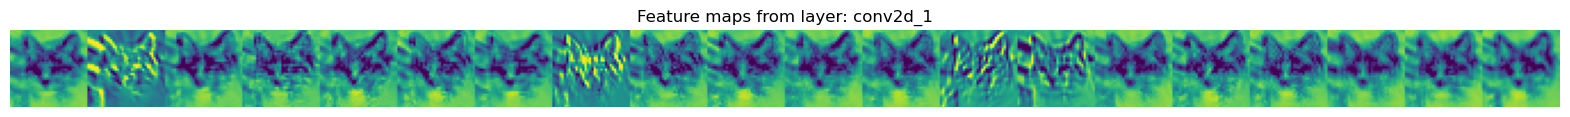

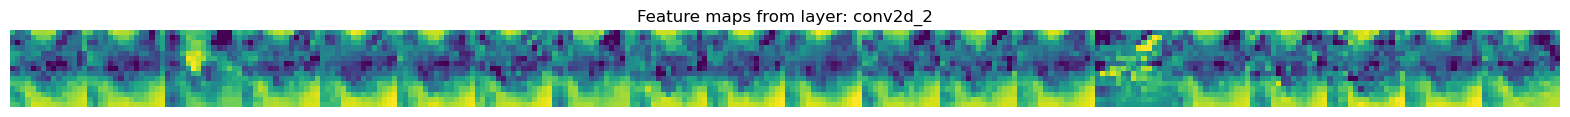

In [38]:
# Välj en katt-bild från testmängden
sample_img = X_train[0]

# Visualisera aktiveringar
visualize_feature_maps(model, sample_img)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


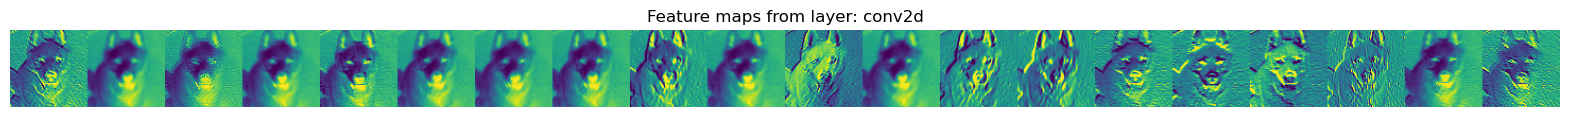

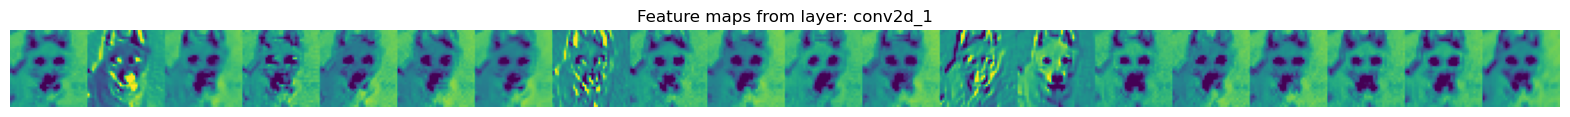

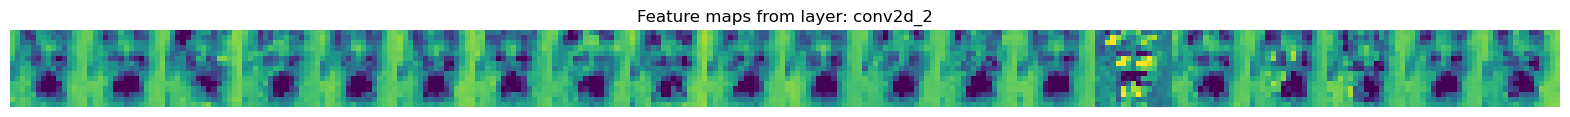

In [40]:
# Välj en hund-bild från testmängden
sample_img = X_train[1]

# Visualisera aktiveringar
visualize_feature_maps(model, sample_img)